Import AlphaTims libraries to use them (NOTE: this can take a while):

In [1]:
import alphatims.utils
import alphatims.bruker
import numpy as np
from matplotlib import pyplot as plt

When an editable version is installed (`pip install -e ./alphatims --use-feature=2020-resolver`), libraries can interactively be reloaded with the following command when the source code is modified:

In [2]:
import importlib

def reload():
    importlib.reload(alphatims.bruker)
    importlib.reload(alphatims.utils)

Some functions can be multithreaded. Thread count can be set with:

In [3]:
# NOTE, default only 1 thread is used
# Set threads to 0 to use the maximum available
alphatims.utils.set_threads(0)

Log files can be saved. By default this is done in the logs folder of the AlphaTims directory, but a custom directory or file name can be provided as well:

In [4]:
alphatims.utils.set_logger(
    log_file_name=""
)

A complete Bruker .d folder can be read into memory (IMPORTANT NOTE: available RAM memory should be roughly twice the size of the Bruker .d folder) with the following command:

In [5]:
reload()
bruker_d_folder_name = "D:/data/raw/20201016_tims03_Evo03_PS_SA_HeLa_200ng_300-1200_2steps_16scans_06-15_5_6min_4cm_S1-A4_1_21720.d"
%time data = alphatims.bruker.TimsTOF(bruker_d_folder_name)

2020-11-10 18:56:08 INFO - Importing data for D:/data/raw/20201016_tims03_Evo03_PS_SA_HeLa_200ng_300-1200_2steps_16scans_06-15_5_6min_4cm_S1-A4_1_21720.d
2020-11-10 18:56:09 INFO - Reading frames for D:/data/raw/20201016_tims03_Evo03_PS_SA_HeLa_200ng_300-1200_2steps_16scans_06-15_5_6min_4cm_S1-A4_1_21720.d
2020-11-10 18:56:09 INFO - Reading bruker dll file \\tsclient\swillems\documents\software\alphatims\alphatims\ext\timsdata.dll
2020-11-10 18:56:09 INFO - Opening handle for D:/data/raw/20201016_tims03_Evo03_PS_SA_HeLa_200ng_300-1200_2steps_16scans_06-15_5_6min_4cm_S1-A4_1_21720.d
2020-11-10 18:56:09 INFO - Reading scans for D:/data/raw/20201016_tims03_Evo03_PS_SA_HeLa_200ng_300-1200_2steps_16scans_06-15_5_6min_4cm_S1-A4_1_21720.d
2020-11-10 18:56:13 INFO - Closing handle for D:/data/raw/20201016_tims03_Evo03_PS_SA_HeLa_200ng_300-1200_2steps_16scans_06-15_5_6min_4cm_S1-A4_1_21720.d
Wall time: 5.76 s


Data in the Bruker TimsTOF data is stored and accessible by `frame/scan/TOF indices` and `rt/mobility/mz values`.

Interaction with the Bruker timsTOF data can be done efficiently with slicing.

Currently, this always requires a slice triplet with the following structure:
* Slice 1: LC with `frame_indices` (integers) or `rt_values` (float) in seconds $s$
* Slice 2: TIMS with `scan_indices` (integers) or `mobility_values` (float) in $\frac{1}{k_0}$
* Slice 3: Quadrupole with `quad_mz_values` (float/integers) in precursor $m/z$. Use -1 to select precursor/MS1 frames without quadrupole filtering. Note that this slice includes the slice_stop.
* Slice 4: TOF with `tof_indices` (integers) or `mz_values` (float) in $m/z$

In [6]:
%%timeit
selected_indices = data[200.: 210., 400: 500, -1:600, 183103: 600.6]

171 µs ± 76.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Conversion functions are defined for the data, such as e.g.:

In [7]:
low_mz_value = 621.9
high_mz_value = 622.1
low_tof_index, high_tof_index = data.convert_to_indices(
    [low_mz_value, high_mz_value],
    to_tof_indices=True
)
print(f"Mz value {low_mz_value} corresponds to a TOF index of {low_tof_index}")

scan_index = 400
mobility_value, = data.convert_from_indices(
    scan_indices=[scan_index],
    to_mobility_values=True
)[0]
print(f"Scan index {scan_index} corresponds to a mobility value of {mobility_value:.3}")

Mz value 621.9 corresponds to a TOF index of 188699
Scan index 400 corresponds to a mobility value of 1.11


Slicing of the data returns `raw_indices`, which always need to be converted to `frame/scan/TOF indices` or `rt/mobility/mz values`.

In [8]:
# NOTE, including a step for frame slicing allows to select e.g. only precursor (MS1) frames in a DIA sample
raw_indices = data[::17, :, :, low_mz_value:high_mz_value]
ms1_indices = data[::, :, -1:-1, low_mz_value:high_mz_value]
assert np.all(ms1_indices == raw_indices)
print(f"{raw_indices.size} raw indices satisfy the selected slice.")
print(f"The raw indices are {raw_indices}.")
(
    frame_indices,
    scan_indices,
    quad_indices,
    tof_indices,
    rt_values,
    mobility_values,
    quad_low_mz_values,
    quad_high_mz_values,
    mz_values
) = data.convert_from_indices(
    raw_indices,
    to_frame_indices=True,
    to_scan_indices=True,
    to_quad_indices=True,
    to_tof_indices=True,
    to_rt_values=True,
    to_mobility_values=True,
    to_quad_mz_values=True,
    to_mz_values=True
)
print(f"Conversion results in e.g. tof_indices {tof_indices}.")

14730 raw indices satisfy the selected slice.
The raw indices are [    62321     96356    139500 ... 158526763 158532745 158547715].
Conversion results in e.g. tof_indices [188749 188748 188746 ... 188713 188712 188725].


Raw indices can be binned in 1D and visualized as XICs, mobilograms and spectra.

Alternatively, they can be binned in 2D and be visualized as heatmaps.

<IPython.core.display.Javascript object>


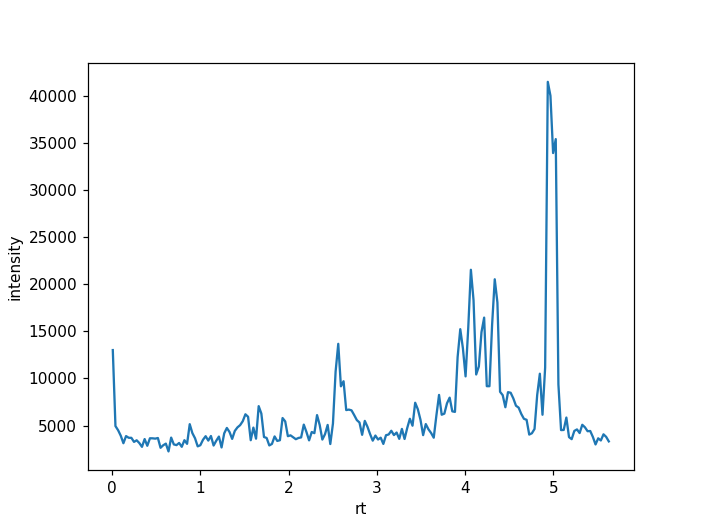

In [9]:
%matplotlib notebook
intensities = data.bin_intensities(raw_indices, ["rt"])
plt.plot(
    data.rt_values[::17] / 60,
    intensities[::17]
)
tmp = plt.xlabel("rt")
tmp = plt.ylabel("intensity")

<ipython-input-10-a766c7c966df>:4: RuntimeWarning: divide by zero encountered in log
  np.log(intensities[::17].T),


<IPython.core.display.Javascript object>


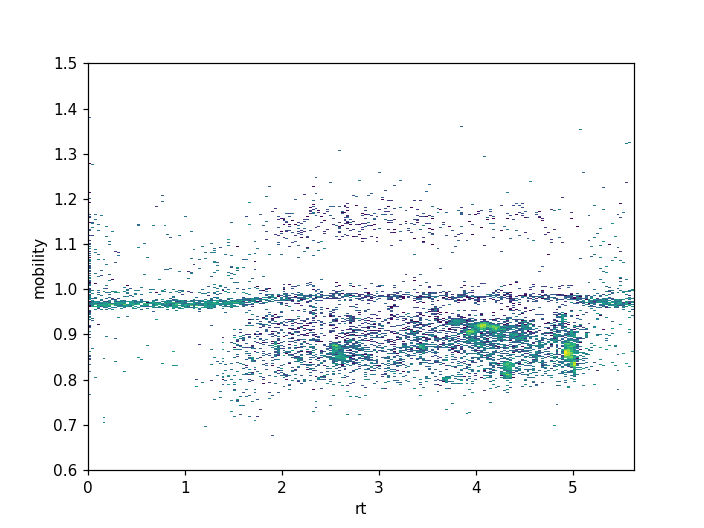

In [10]:
%matplotlib notebook
intensities = data.bin_intensities(raw_indices, ["rt", "mobility"])
plt.imshow(
    np.log(intensities[::17].T),
    extent=[
        0,
        np.max(data.rt_values) / 60,
        data.mobility_min_value,
        data.mobility_max_value
    ],
    aspect="auto"
)
tmp = plt.xlabel("rt")
tmp = plt.ylabel("mobility")

<ipython-input-11-fecac7c015ae>:4: RuntimeWarning: divide by zero encountered in log
  np.log(intensities[::17, low_tof_index: high_tof_index]).T,


<IPython.core.display.Javascript object>


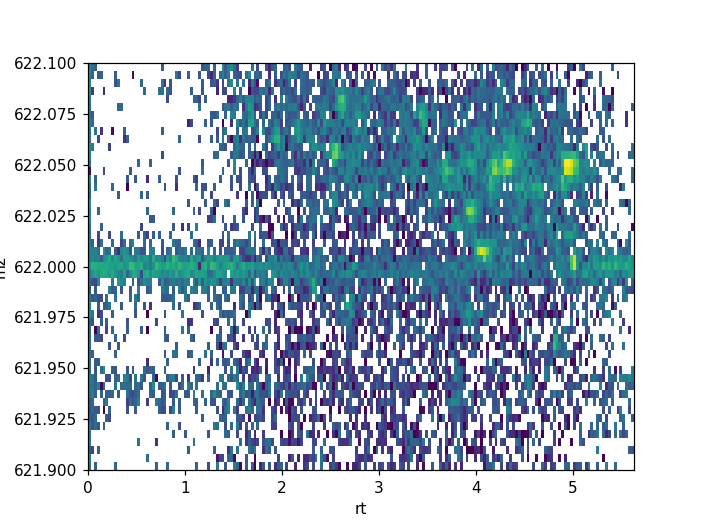

In [11]:
%matplotlib notebook
intensities = data.bin_intensities(raw_indices, ["rt", "mz"])
plt.imshow(
    np.log(intensities[::17, low_tof_index: high_tof_index]).T,
    extent=[
        0,
        np.max(data.rt_values) / 60,
        low_mz_value,
        high_mz_value
    ],
    aspect="auto"
)
tmp = plt.xlabel("rt")
tmp = plt.ylabel("mz")

<ipython-input-12-92be7e6c4b35>:4: RuntimeWarning: divide by zero encountered in log
  np.log(intensities[low_tof_index: high_tof_index]).T,


<IPython.core.display.Javascript object>


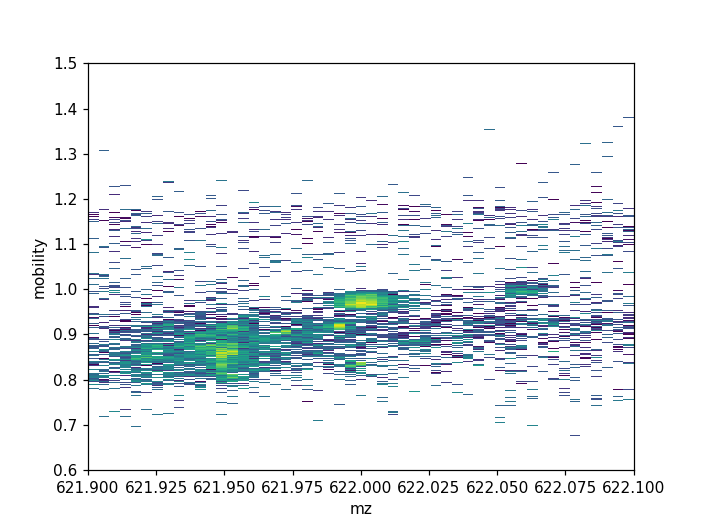

In [12]:
%matplotlib notebook
intensities = data.bin_intensities(raw_indices, ["mz", "mobility"])
plt.imshow(
    np.log(intensities[low_tof_index: high_tof_index]).T,
    extent=[
        low_mz_value,
        high_mz_value, 
        data.mobility_min_value,
        data.mobility_max_value        
    ],
    aspect="auto"
)
tmp = plt.xlabel("mz")
tmp = plt.ylabel("mobility")